In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

# Gaussian Interval Estimation Example

Let's explore interval estimation with a Gaussian example.  We will use random numbers drawn from a Poisson distribution to test interval estimation using the method of Maximum Likelihood, confidence belts, and hypothesis test inversion (the last two are the same, just different in implementation!).

The data will be drawn from a Gaussian, so we should expect that both the ML estimate using a Gaussian PDF or a Poisson PDF should both agree reasonably well with we get from the confidence belt and inverted hypothesis test.

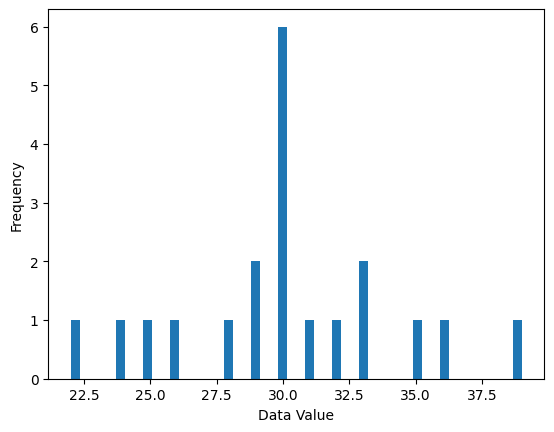

In [2]:
def generateData(mean, nData):
    return np.random.poisson(mean,nData)

gMean = 30
nData = 20
testData = generateData(gMean,nData)

plt.hist(testData,50)
plt.xlabel("Data Value")
plt.ylabel("Frequency")
plt.show()

In [3]:
# This is the Gaussian log-likelhood function.
# The data is Poisson, so let's assume we can use the mean as the variance
# Clearly this is an assumption, but we have to choose something for the variance term
def lhood_func_gaussian(ymodel,ydata):
    return -0.5*np.pow((ydata - ymodel),2)/ymodel 

# This is the Poisson log-likelihood function.
# We don't have to assume anything about the variance here because that's not a parameter of the Poisson PDF
def lhood_func_poisson(ymodel,ydata):
    return ydata*np.log(ymodel) - ymodel

# This function will sum the log-likelihood over each data event.
# Recall that we are taking the log of the joint PDF over all data events, which is the product.
# After taking the log, we get a sum.
def loglikelihood(pMean, data, doGaus = True):
    loglhood = 0

    for i in range(len(data)):
        if doGaus:
            loglhood += lhood_func_gaussian(pMean,data[i])
        else:
            loglhood += lhood_func_poisson(pMean,data[i])
            
    return loglhood

# Find LLH for a range of mean values
# On the fly, find the maximum LLH value
def findMaxima(data, llhood, meanVals,_gaus = True):
    maxLH = -1E7
    mbest = 0
    for x, m in enumerate(meanVals):
        llhood[x] = loglikelihood(m,data,doGaus=_gaus)
        if llhood[x] > maxLH:
            maxLH = llhood[x]
            mbest = m
            
    return mbest, maxLH

# If we move down the LLH curve by 0.5 from the peak, we find the +/-1 standard deviation values
# This is an estimate of the 1-standard deviation interval
def getStdDevVals(llhood,mvals,maxLH):
    meanP1 = 0
    meanP2 = 0
    foundFirst1 = False
    foundFirst2 = False
    for i in range(0,len(llhood)):
        if (llhood[i]> (maxLH-0.5)) and (foundFirst1 == False):
            meanP1 = mvals[i]
            foundFirst1 = True

        if (llhood[i]< (maxLH-0.5)) and (foundFirst1 == True) and (foundFirst2==False):
            meanP2 = mvals[i]
            foundFirst2 = True
    return meanP1, meanP2


In [4]:
# Set up arrays to hold our mean values and LLH values
steps = 10000
llhoodG = np.zeros(steps)
llhoodP = np.zeros(steps)
mMin = 25
mMax = 35
meanVals = np.arange(mMin,mMax,(mMax-mMin)/steps)

# Generate LLH data and find maxima
mbestG, maxG = findMaxima(testData, llhoodG, meanVals, _gaus=True)
mbestP, maxP = findMaxima(testData, llhoodP, meanVals, _gaus=False)

# The Gaussian and Poisson LLH values are not required to have the same maximum value.
# To aid plotting, we can simply remove the difference in the maximum values
# Note that this doesn't impact the interval estimation!
llhoodG += maxP-maxG

# Find +/-1 standard deviation values
std1G, std2G = getStdDevVals(llhoodG,meanVals,maxP)
std1P, std2P = getStdDevVals(llhoodP,meanVals,maxP)



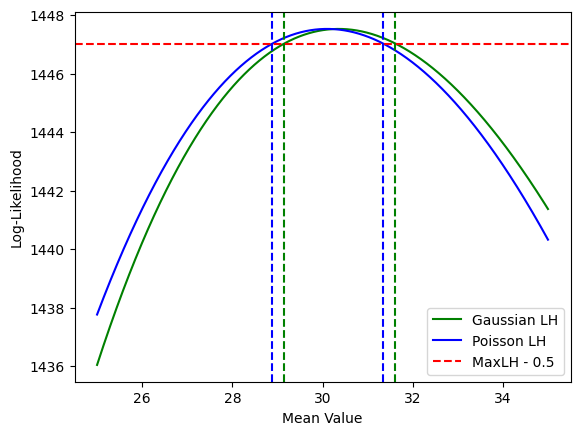

Gaussian Mean +/- Interval: 30.358 -1.207 1.258
 Poisson Mean +/- Interval: 30.100 -1.210 1.244


In [8]:
# Make the plot!
plt.plot(meanVals,llhoodG,c='g',label="Gaussian LH")
plt.plot(meanVals,llhoodP,c='b',label="Poisson LH")
plt.axhline(y=maxP-0.5,c='r',linestyle="--",label = "MaxLH - 0.5")
plt.axvline(x=std2P,c='b',linestyle="--")
plt.axvline(x=std1P,c='b',linestyle="--")
plt.axvline(x=std2G,c='g',linestyle="--")
plt.axvline(x=std1G,c='g',linestyle="--")
plt.xlabel("Mean Value")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()

# Report intervales
print("Gaussian Mean +/- Interval: {:.3f} {:.3f} {:.3f}".format(mbestG,std1G-mbestG,std2G-mbestG))
print(" Poisson Mean +/- Interval: {:.3f} {:.3f} {:.3f}".format(mbestP,std1P-mbestP,std2P-mbestP))

## Does that make sense??

We used two different PDF assumptions for the method of Maximum Likelihood.  And we found two different 1 standard deviation intervals (ie, 68.27\% Confidence Level).  Is that OK?

Yes, it's fine!  Your assumptions about the underlying random PDF from whence the data was drawn will impact your conclusions!  There's nothing wrong with your INTERPRETATION depending on your ASSUMPTIONS.


# Now let's work with the confidence belt method to find an interval

To do this correctly, we need to "know" the sampling distribution for the mean value estimator.  I write "know" because obviously we will have to make some assumptions about the PDF of the sampling distribution, but our guesses will be educated ones.

We know the mean value has an estimator that should be very familiar: $$ \hat{\mu} = {1 \over N} \sum_{i=1}^N x_i$$

And if you recall Lecture 15 from this course, we recall that the variance of the sampling distribution of the mean is the true PDF variance divided by the number of data points $$N$$. Given that the variance of the Poisson PDF is the mean of the Poisson PDF, we can find the expected variance of the mean estimator sampling distribution to be: $$ \sigma_{\hat{\mu}} = \sqrt{\mu \over N}$$

Now, you might point out that I don't strictly KNOW the mean of the true, underlying Poisson PDF.  That's fair.  But because I'm generating PDFs of sampling distributions for known mean values....I therefore know the mean of the PDF I'm working with.

Putting it all together, we will form sampling distribution PDFs for a range of true mean values.  For each true mean value, I can find the +/-1 standard deviation interval for its mean value sampling distribution.  These values form the confidence belt.  Then it's just a matter of finding the points where the observed mean value intersects the confidence belt.

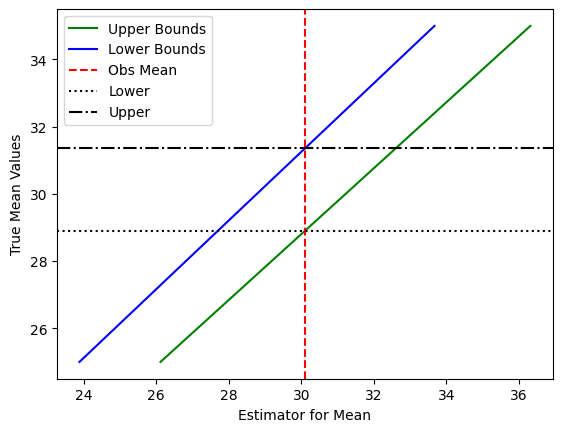

Found Mean +/- Interval: 30.100 -1.202 1.252


In [19]:
# For completeness and clarity, let's define the p-values that define the confidence belt.
# We are using the +/-1 standard deviation points by construction below, but these are the
# associated p-values
alpha = (1-0.6827)/2
beta = (1-0.6827)/2

# Arrays for the upper and lower interval values
uVals = np.zeros(steps)
vVals = np.zeros(steps)

# Mean value for our random data
testMean = np.mean(testData)

# Scan over the true mean values to first define the confidence belt values
# and second to find the points where the observed mean estimate intersects
# the confidence belt.
uFound = 0
uMin = 100
vFound = 0
vMin = 100
for i, m in enumerate(meanVals):
    # The sampling distribution of the mean estimator PDF has an expected mean given by the true mean (unbiased)
    # And it has a variance given by the mean divided by the number of data values in the sample.
    uVals[i] = m + np.sqrt(m/nData)
#    print(uVals[i], testMean, uVals[i]-testMean)
    if abs(uVals[i]-testMean)<uMin:
        uFound = m
        uMin = abs(uVals[i]-testMean)
    
    vVals[i] = m - np.sqrt(m/nData)
    if abs(vVals[i]-testMean)<vMin:
        vFound = m
        vMin = abs(vVals[i]-testMean)

# Plot it!
plt.plot(uVals,meanVals,c='g',label="Upper Bounds")
plt.plot(vVals,meanVals,c='b',label="Lower Bounds")
plt.axvline(x=testMean,c='r',linestyle="--", label = "Obs Mean")
plt.axhline(y=uFound,c='k',linestyle="dotted", label = "Lower")
plt.axhline(y=vFound,c='k',linestyle="dashdot", label = "Upper")
plt.xlabel("Estimator for Mean")
plt.ylabel("True Mean Values")
plt.legend()
plt.show()

print("Found Mean +/- Interval: {:.3f} {:.3f} {:.3f}".format(testMean,uFound-testMean,vFound-testMean))

### And now the inverted hypothesis test style

It's truly the same thing, but performed in a somewhat different manner.  What we will do is build imaginary mean estimator sampling distribution PDFs, both above and below the observed mean value estimate.  We will increase the mean of the PDFs from below (or from above) until they have a p-value consistent with the value we predefined above (alpha and beta).  For a +/-1 standard deviation interval, those p-values have the same value of (1-0.6827)/2.

Found Mean +/- Interval: 30.100 -1.202 1.252


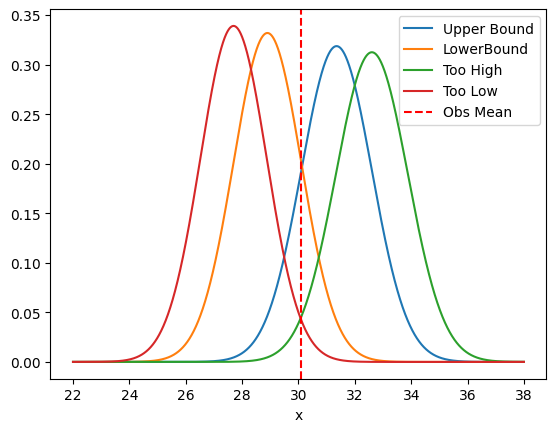

In [22]:
import math
from scipy import stats


# Treat the PDFs as Gaussian (they should be!) and find the p-value realtive to the observed mean estimate
def gausCDF(mean,tMean,tSigma):
    return (1/2) * (1 + math.erf((mean- tMean) / (tSigma * np.sqrt(2))))


# Start at a mean value of 20 and walk up until we find the first true value that gives us
# a p-value of the right size
lowerBound = 0
lFound = False
for m in np.arange(20,35,0.0001):
    if (gausCDF(m,testMean,np.sqrt(m/nData)) > alpha) and (lFound == False):
        lowerBound = m
        lFound = True

# Start at a mean value of 25 and walk up until we find the first true value that gives us
# a p-value of the right size
upperBound = 0
uFound = False
for m in np.arange(25,40,0.0001):
    if (gausCDF(m,testMean,np.sqrt(m/nData)) >(1-beta)) and (uFound == False):
        upperBound = m
        uFound = True

print("Found Mean +/- Interval: {:.3f} {:.3f} {:.3f}".format(testMean,lowerBound-testMean,upperBound-testMean))

# Generate some data
x = np.linspace(22, 38, 10000)
upper = stats.norm.pdf(x, upperBound, np.sqrt(upperBound/nData))  
lower = stats.norm.pdf(x, lowerBound, np.sqrt(lowerBound/nData))  
upper1S = stats.norm.pdf(x, upperBound+np.sqrt(upperBound/nData), np.sqrt((upperBound+np.sqrt(upperBound/nData))/nData))  
lower1S = stats.norm.pdf(x, lowerBound-np.sqrt(lowerBound/nData), np.sqrt((lowerBound-np.sqrt(lowerBound/nData))/nData))    

# Plot the Gaussian distribution
plt.plot(x, upper,label="Upper Bound")
plt.plot(x, lower,label="LowerBound")
plt.plot(x, upper1S,label="Too High")
plt.plot(x, lower1S,label="Too Low")
plt.xlabel("x")
plt.axvline(x=testMean,c='r',linestyle="--", label = "Obs Mean")
plt.legend()
plt.show()